In [14]:
from osgeo import gdal
import h5py
import numpy as np
import matplotlib.pyplot as plt
import fiona
import rasterio
import rasterio.mask
import os

In [91]:
shp_pth= '/home/allen/Documents/Projects/Harvey/excessive_rain/subbasins/08076700.shp'
with fiona.open(shp_pth, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

In [124]:
QPE_dir='/home/allen/Documents/Projects/Ensemble_Nowcast/MRMS/20170826'
QPF_dir='/home/allen/Documents/Projects/Ensemble_Nowcast/extrapolation/20170826'

In [128]:
#read in HRRR
#hrrr.t12z.wrfsfcf00.grib2.rainrate_warp.tif
HRRRs= []
for i, hour in enumerate(pd.date_range('20170826120000', '20170826145400', freq='1H')):
    HRRR_fname= '/home/allen/Documents/Projects/Ensemble_Nowcast/HRRR/hrrr.t12z.wrfsfcf%02d.grib2.rainrate_warp.tif'%(i)

    with rasterio.open(HRRR_fname) as src:
        HRRR, _ = rasterio.mask.mask(src, shapes, crop=True)
        HRRR*= 3600
        df.loc[hour,'HRRR']= np.nanmean(HRRR)
        HRRRs.append(HRRR)
HRRRs=np.stack(HRRRs)

In [95]:
delta= pd.Timedelta('6M')
dr= pd.date_range('20170826120000', '20170826145400', freq='0.1H')
df= pd.DataFrame(index=dr)
QPEs=[]
QPFs=[[]]
for hour in dr:
    print(hour)
    fname= hour.strftime('PrecipRate_00.00_%Y%m%d-%H%M%S.grib2-var0-z0.tif')
    QPE_pth= os.path.join(QPE_dir, fname)
    with rasterio.open(QPE_pth) as src:
        QPE, _ = rasterio.mask.mask(src, shapes, crop=True)
        QPEs.append(QPE)
    df.loc[hour, 'QPE']= np.nanmean(QPE)
    for mem in range(10):
        QPF_pth= os.path.join(QPF_dir, '2017082612', fname[:-4]+'_mem%02d.tif'%mem)
        with rasterio.open(QPF_pth) as src:
            _QPF=rasterio.mask.mask(src, shapes, crop=True)[0]
        _QPF[_QPF<0]= np.nan
        _QPF[_QPF>200]= np.nan
        QPFs[-1].append(_QPF)
    
        df.loc[hour,'QPF_%d'%mem]= np.nanmean(_QPF)
    QPFs.append([])
del QPFs[-1]
QPFs= np.stack(QPFs)
QPEs= np.stack(QPEs)

2017-08-26 12:00:00
2017-08-26 12:06:00
2017-08-26 12:12:00
2017-08-26 12:18:00
2017-08-26 12:24:00
2017-08-26 12:30:00
2017-08-26 12:36:00
2017-08-26 12:42:00
2017-08-26 12:48:00
2017-08-26 12:54:00
2017-08-26 13:00:00
2017-08-26 13:06:00
2017-08-26 13:12:00
2017-08-26 13:18:00
2017-08-26 13:24:00
2017-08-26 13:30:00
2017-08-26 13:36:00
2017-08-26 13:42:00
2017-08-26 13:48:00
2017-08-26 13:54:00
2017-08-26 14:00:00
2017-08-26 14:06:00
2017-08-26 14:12:00
2017-08-26 14:18:00
2017-08-26 14:24:00
2017-08-26 14:30:00
2017-08-26 14:36:00
2017-08-26 14:42:00
2017-08-26 14:48:00
2017-08-26 14:54:00


In [96]:
from matplotlib import cm

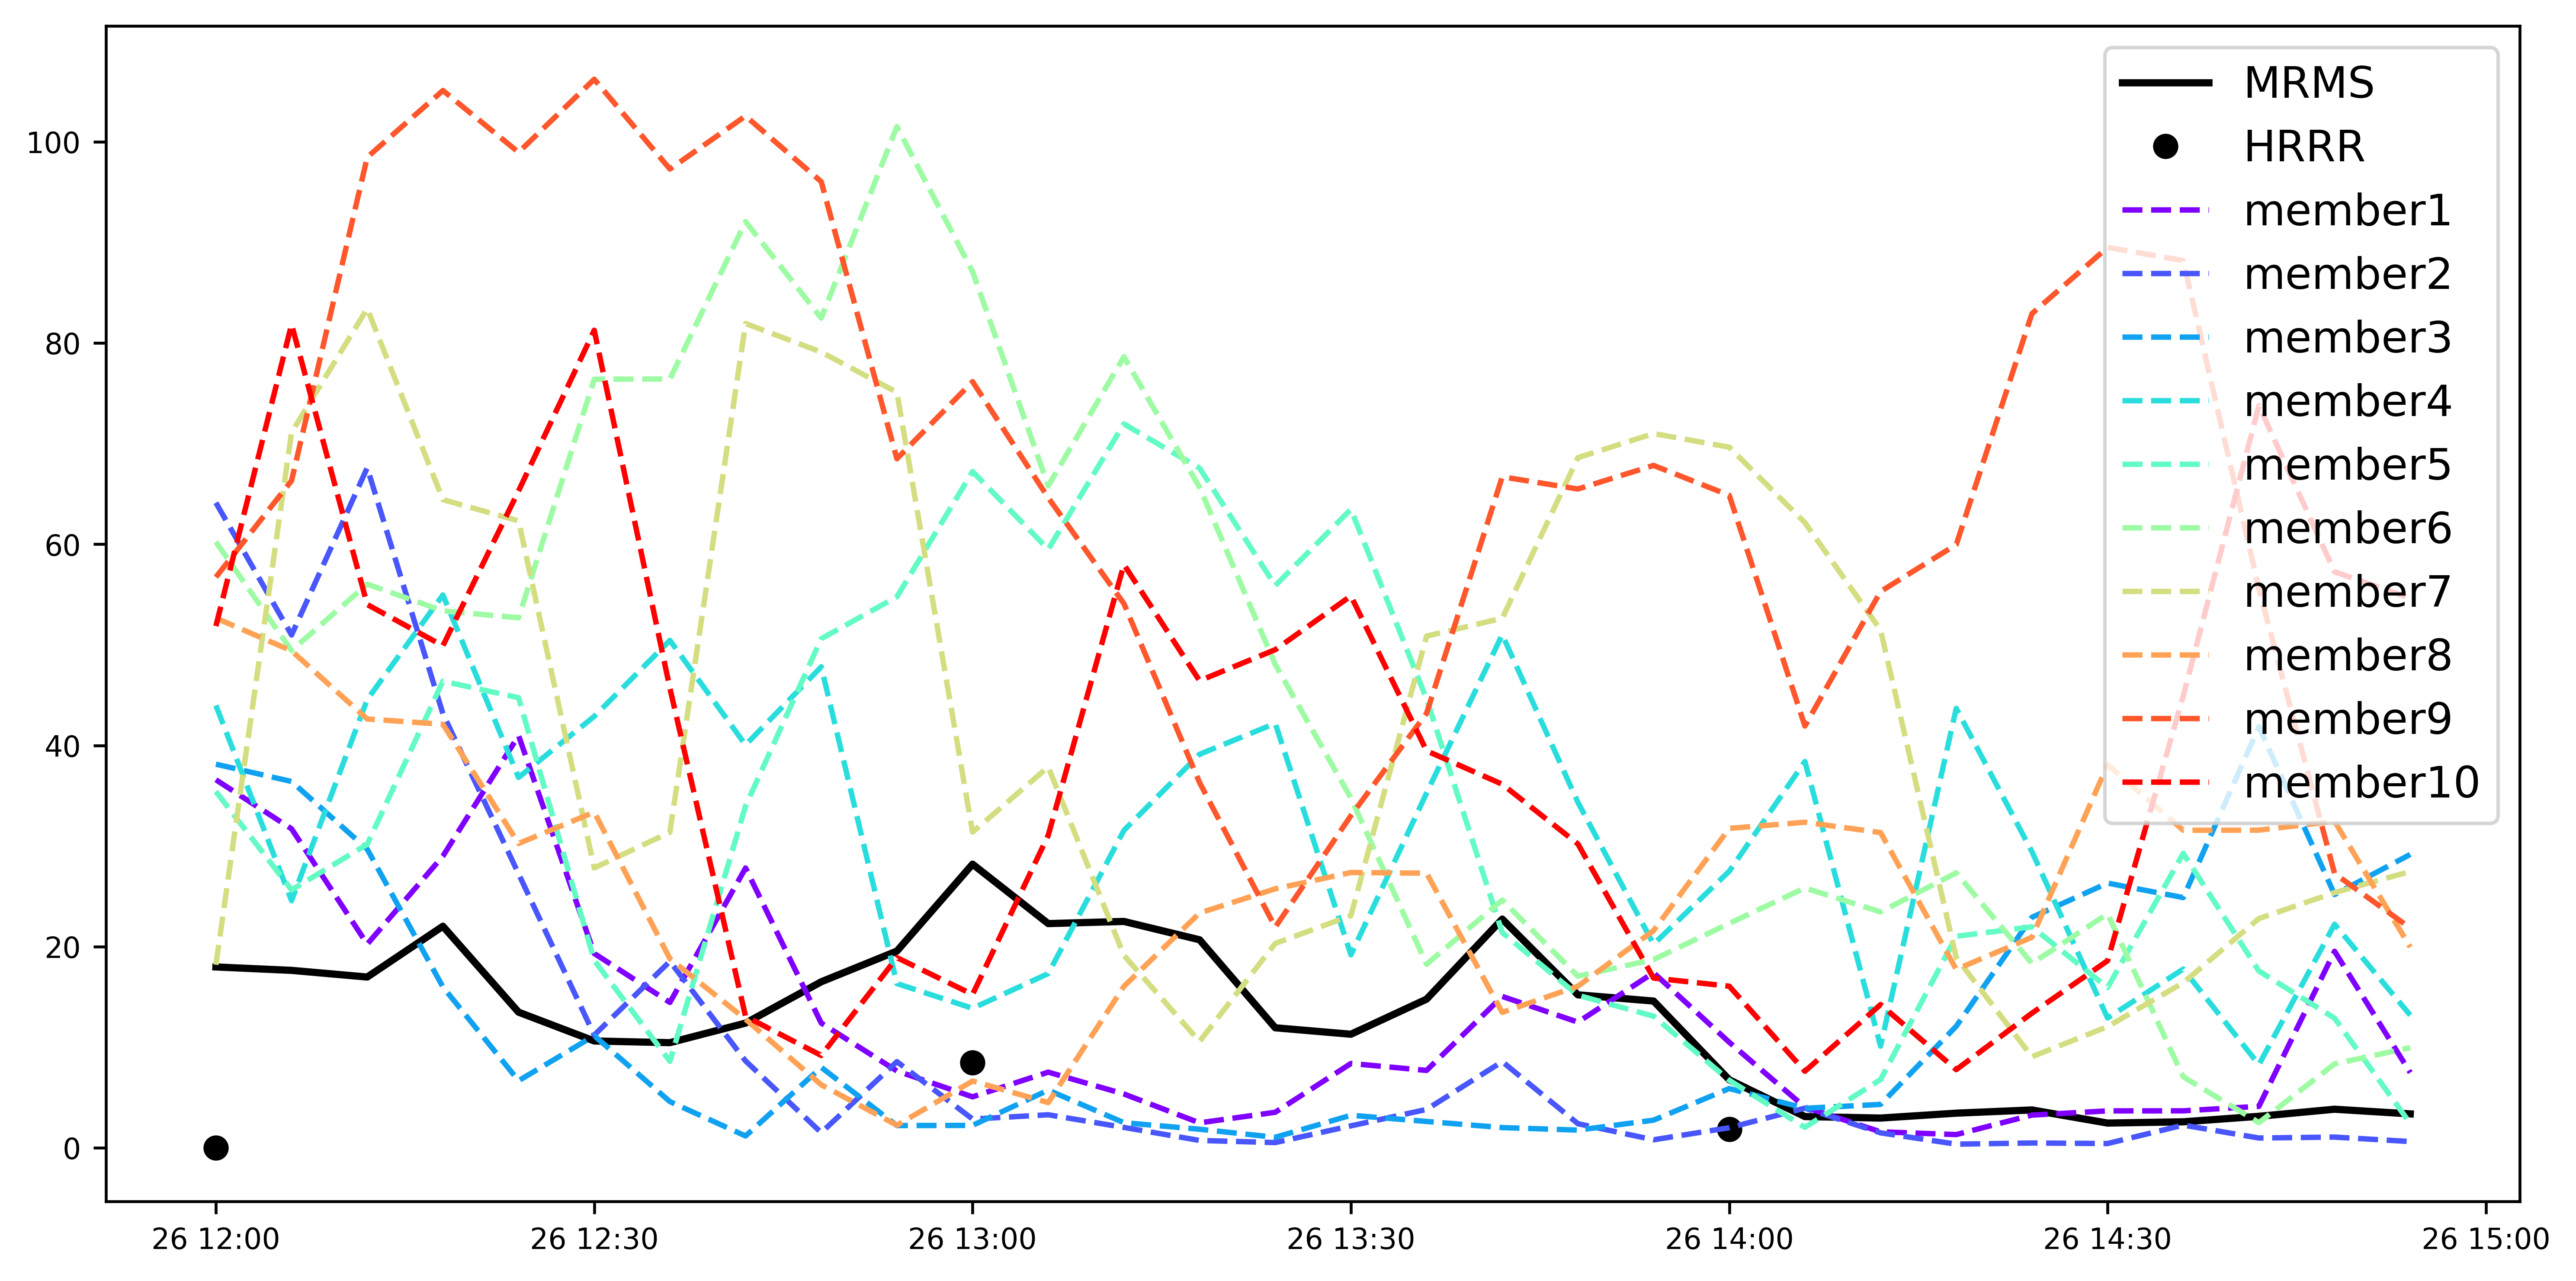

In [129]:
evenly_spaced_interval = np.linspace(0, 1, 10)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]
fig= plt.figure(figsize=(12,6))
ax= fig.add_subplot(111)
ax.plot(df.index, df.QPE, color='k', label='MRMS', linewidth=2)
ax.plot(df.index, df.HRRR, 'ko', label='HRRR')
for i in range(10):
    ax.plot(df.index, df.loc[:, 'QPF_%d'%i], linestyle='dashed', color=colors[i], label='member%d'%(i+1))
plt.legend(fontsize=12)

In [130]:
fig.savefig('src/ts.basin.avg.201708261200.png',dpi=300)

In [101]:
from pysteps.visualization import plot_precip_field, motionfields, animate, quiver

In [131]:

fig=plt.figure(figsize=(10,20))
ax= fig.add_subplot(6,2,1)
plot_precip_field(np.nansum(QPEs,axis=0).squeeze()/10.,ax=ax, units='mm', type='depth', axis='off')
ax.set_title('MRMS', weight='bold', fontsize=16)
ax.axis('off')

ax= fig.add_subplot(6,2,2)
plot_precip_field(np.nansum(HRRRs,axis=0).squeeze(), ax=ax, units='mm', type='depth', axis='off')
ax.set_title('HRRR', weight='bold', fontsize=16)
ax.axis('off')

for i in range(10):
    ax= fig.add_subplot(6,2,i+3)
    ax.set_title('Member %d'%(i+1), weight='bold', fontsize=16)
    plot_precip_field(np.nansum(QPFs,axis=0).squeeze()[i]/10.,ax=ax, units='mm', type='depth', axis='off')
    ax.axis('off')


plt.tight_layout()
# fig.savefig('animation/None_t_%02d.png'%t)
# plt.close()

/home/allen/Documents/Programs/miniconda3/envs/dl/lib/python3.7/site-packages/pysteps-1.3.1-py3.7-linux-x86_64.egg/pysteps/visualization/precipfields.py:278: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cax=cax,
/home/allen/Documents/Programs/miniconda3/envs/dl/lib/python3.7/site-packages/matplotlib/image.py:447: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/allen/Documents/Programs/miniconda3/envs/dl/lib/python3.7/site-packages/matplotlib/image.py:454: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/allen/Documents/Programs/miniconda3/envs/dl/lib/python3.7/site-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/allen/Documents/Programs/mini

In [132]:
fig.savefig('src/ts.basin.acc.201708261200.png',dpi=300)